# Imporowanie 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from corona_analysis.utils import save, paths
from pathlib import Path
from corona_analysis.scrapers import healthdata, koronawirusunas, meteostat, policjapl, rmf24, wiki_demo, wiki_urban

plt.rcParams.update({'font.size': 22})

# Wczywanie danych

In [29]:
df = pd.read_csv(Path(paths.get_path(abs_path=Path(os.getcwd()).parents[0]),"df.csv"), index_col=0, parse_dates=True, dayfirst=True)

In [34]:
woj = koronawirusunas.SUB_SITES
wojewodztwa = pd.DataFrame()
for i in range(1, len(woj)):
    dat = pd.read_csv(Path(paths.get_path(abs_path=Path(os.getcwd()).parents[0]), woj[i][12:] + ".csv"), index_col=0, parse_dates=True, dayfirst=True)
    dat.fillna(axis=1, inplace=True, value=0)
    dat["wojewodztwo"] = np.nan
    dat.fillna(axis=1, inplace=True, value=woj[i][12:])
    dat["date"] = (dat.index - dat.index.min())  / np.timedelta64(1,'D')
    wojewodztwa = wojewodztwa.append(dat)

In [36]:
woj_info = pd.read_csv(Path(paths.get_path(abs_path=Path(os.getcwd()).parents[0]), "woj_info.csv"), index_col=0, parse_dates=True, dayfirst=True)

In [37]:
df = df[df.index >= "2020-03-01"]
df['zar_log'] = np.log(df["confirmed_infections"] + 1)

In [38]:
df['daily_inf'] = df['zar'].diff(1)
df['sum'] = df["confirmed_infections"].cumsum()

In [43]:
df['suma_no_slask'] =  df['zar']
df.loc[min(wojewodztwa.index):max(wojewodztwa.index),'suma_no_slask'] = df.loc[min(wojewodztwa.index):max(wojewodztwa.index)]['suma_no_slask'] - wojewodztwa[wojewodztwa.wojewodztwo == "slaskie"].zar
df['daily_inf_no_slask'] = df['suma_no_slask'].diff(1)

# Wykresy do prezentacji

## dane_marzec

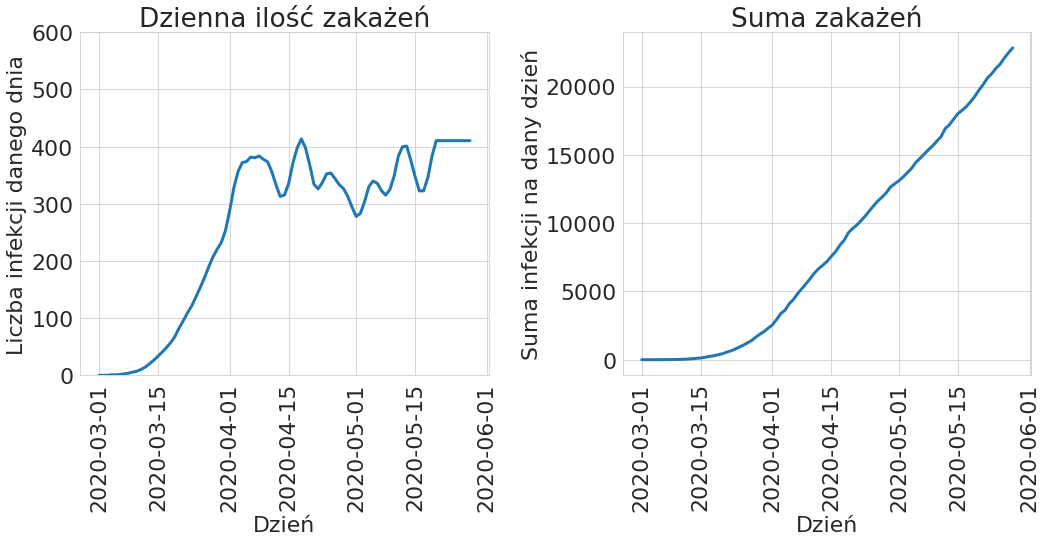

In [192]:
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)

sns.lineplot(x='index', y='confirmed_infections', data=df.reset_index(), legend=False, ax=ax1, linewidth=3)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")
ax1.set_ylim([0,600])
plt.xticks(rotation = 'vertical')

ax2 = plt.subplot(122)
sns.lineplot(x='index', y='zar', data=df.reset_index(), legend=False, ax=ax2, linewidth=3)
ax2.set(ylabel='Suma infekcji na dany dzień', xlabel='Dzień')
ax2.set_title("Suma zakażeń")
plt.xticks(rotation = 'vertical')


plt.tight_layout()

plt.savefig("../img/dane_marzec.png", dpi=200)

## dane_marzec_porownanie

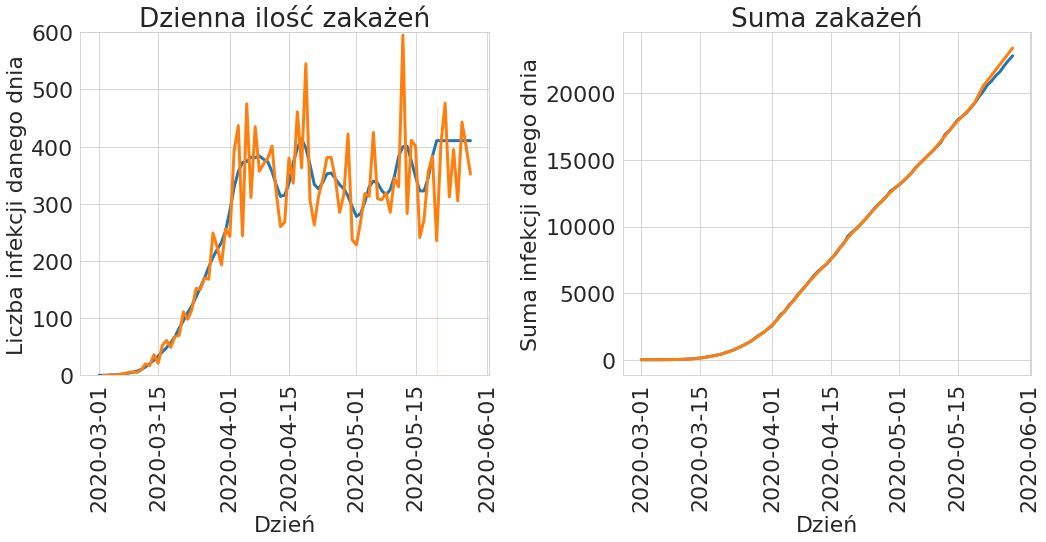

In [193]:
sns.set_style("whitegrid")

plt.figure(figsize=(15,8))


# First plot
ax1 = plt.subplot(121)

sns.lineplot(x='index', y='confirmed_infections', data=df.reset_index(), ax=ax1, linewidth=3)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")

sns.lineplot(x='index', y='daily_inf', data=df.reset_index(), ax=ax1, linewidth=3)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")
ax1.set_ylim([0,600])
plt.xticks(rotation = 'vertical')


# Second plot
ax2 = plt.subplot(122)
sns.lineplot(x='index', y='zar', data=df.reset_index(), legend=False, ax=ax2, linewidth=3)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')
ax2.set_title("Suma zakażeń")
plt.xticks(rotation = 'vertical')

ax2 = plt.subplot(122)
sns.lineplot(x='index', y='sum', data=df.reset_index(), legend=False, ax=ax2, linewidth=3)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')


plt.tight_layout()

plt.savefig("../img/dane_marzec_porownanie.png", dpi=200)

## fazy_w_czasie

<Figure size 1080x576 with 0 Axes>

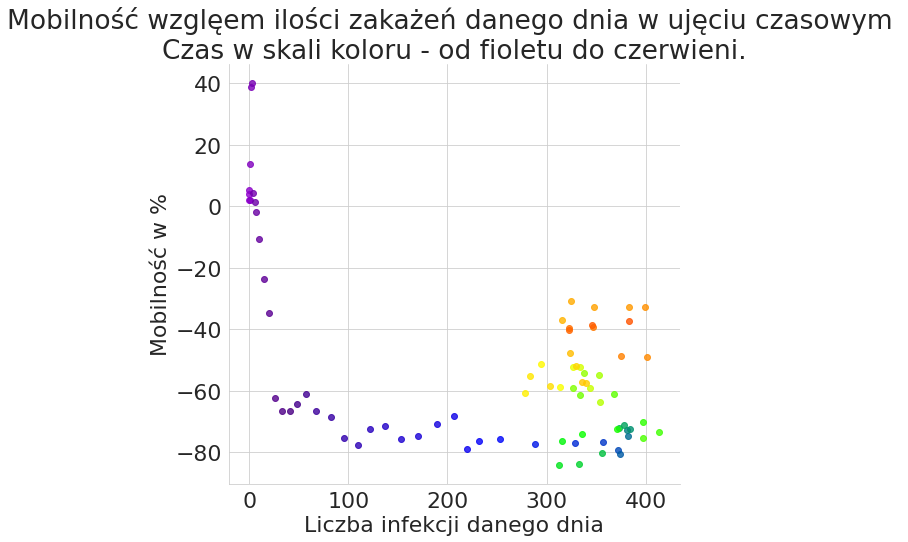

In [67]:
plt.figure(figsize=(15,8))
sns.set_style("whitegrid")

ax = sns.lmplot(x='confirmed_infections', y='pieszo', hue='date', data=df[df.index < "2020-05-20"], palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=len(df['date'])), legend=False, height = 8)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.title("Mobilność wzglęem ilości zakażeń danego dnia w ujęciu czasowym \nCzas w skali koloru - od fioletu do czerwieni.")

plt.tight_layout()
plt.savefig("../img/fazy_w_czasie.png", dpi=200, bbox_inches='tight')

## mobilnosc_infekce_rekomendacje_rzadu

<Figure size 1080x576 with 0 Axes>

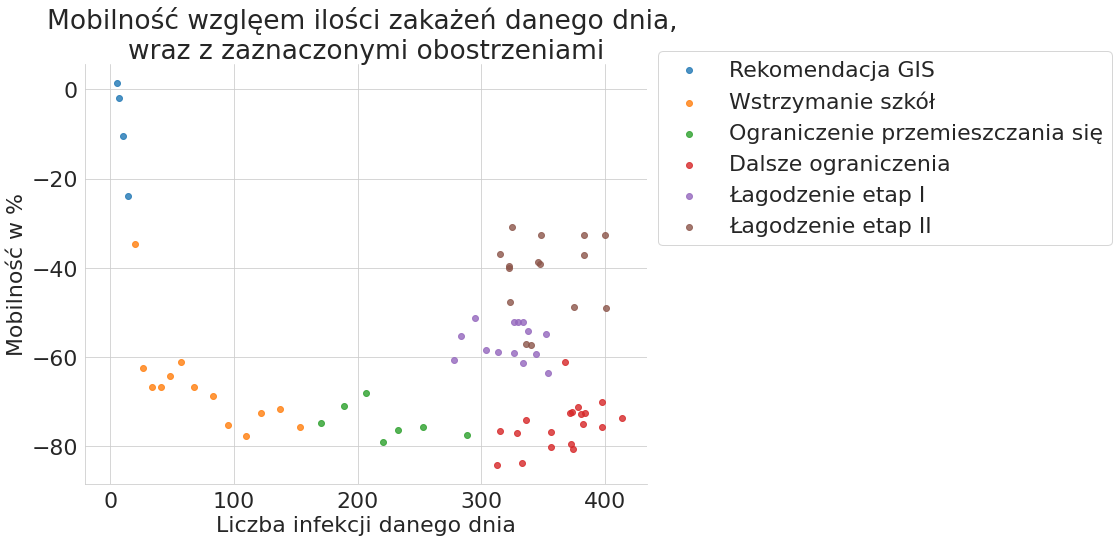

In [106]:
df.loc[df.index > "2020-03-8",'faza'] = 0
df.loc[df.index > "2020-03-12",'faza'] = 1
df.loc[df.index > "2020-03-25",'faza'] = 2
df.loc[df.index > "2020-04-01",'faza'] = 3
df.loc[df.index > "2020-04-20",'faza'] = 4
df.loc[df.index > "2020-05-04",'faza'] = 5

plt.figure(figsize=(15,8))
sns.set_style("whitegrid")

ax = sns.lmplot(x="confirmed_infections", y="pieszo", data=df[df.index < "2020-05-20"], fit_reg= False, height = 8, hue = "faza", legend = False, aspect=2)

ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')

plt.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'], loc='center left', bbox_to_anchor=(1, 0.8))
plt.title("Mobilność wzglęem ilości zakażeń danego dnia, \nwraz z zaznaczonymi obostrzeniami")
plt.tight_layout()
plt.savefig("../img/mobilnosc_infekcje_rekomendacje_rzadu.png", dpi=200, bbox_inches='tight')

## fazy_porownanie

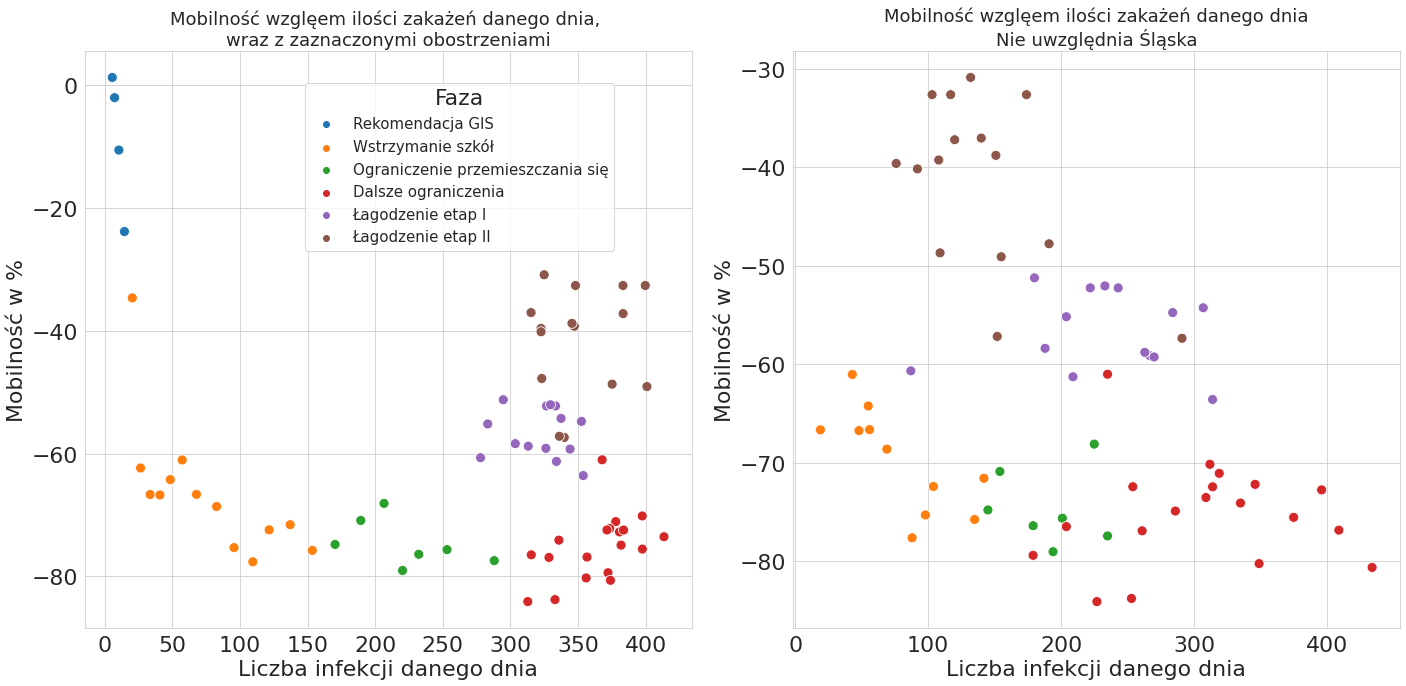

In [176]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

##### LEFT PLOT
g = sns.scatterplot(x="confirmed_infections", y="pieszo", data=df[df.index < "2020-05-20"], hue = "faza", ax=axs[0], palette=sns.color_palette()[0:6], s=100)
# Set ax titles
axs[0].set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')

# Create proper legend
axs[0].legend(loc='center left', bbox_to_anchor=(0.35, 0.8), prop = {'size' : 15})
legend = g.legend_
legend.set_title("Faza")
labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II']
# Set legend labels
for i, label in enumerate(labels):
    # i+1 because i=0 is the title, and i starts at 0
    legend.get_texts()[i].set_text(label) 
# Set title
axs[0].set_title("Mobilność wzglęem ilości zakażeń danego dnia, \nwraz z zaznaczonymi obostrzeniami", fontdict = {'fontsize' : 18})


##### RIGHT PLOT
sns.scatterplot(x="daily_inf_no_slask", y="pieszo", data=df[df.index < "2020-05-20"], hue="faza", ax=axs[1], palette=sns.color_palette()[0:6], s=100, legend=False)
axs[1].set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
axs[1].set_title("Mobilność wzglęem ilości zakażeń danego dnia\nNie uwzględnia Śląska", fontdict = {'fontsize' : 18})

plt.tight_layout()
plt.savefig("../img/fazy_porownanie.png", dpi=200, bbox_inches='tight')

## zar woj

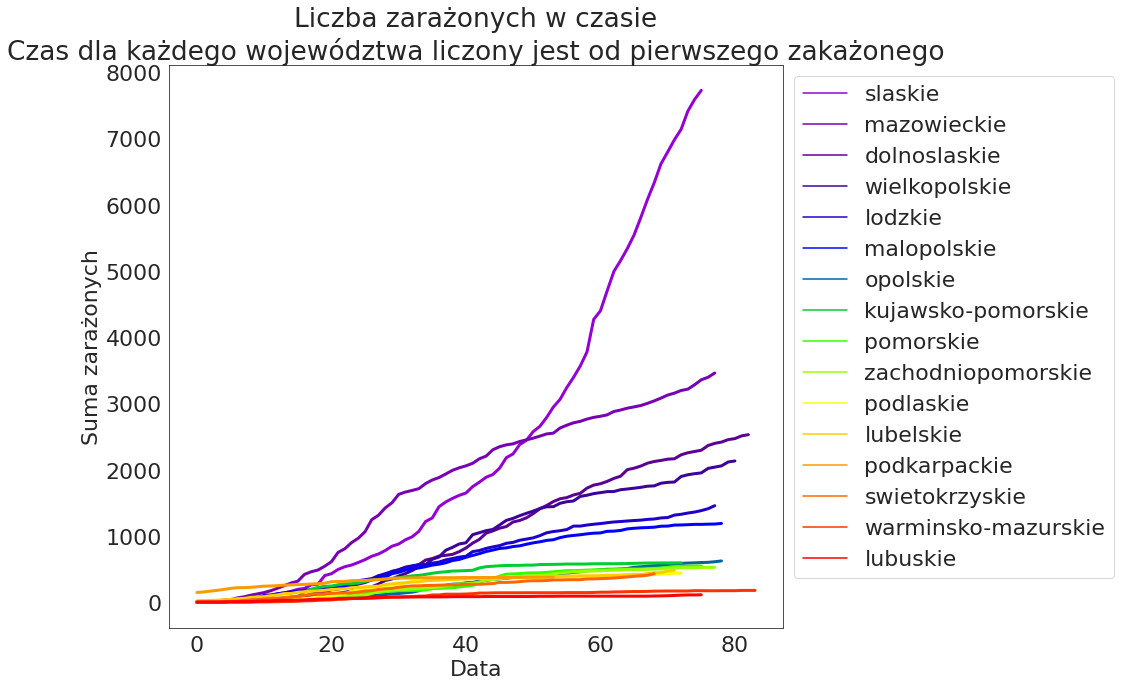

In [190]:
fig = plt.figure(figsize=(15,10))


sns.set_style("white")
ax = sns.lineplot(x = "date", y = "zar", data = wojewodztwa, hue = "wojewodztwo", legend='brief', palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=16), linewidth =3 )
plt.legend(bbox_to_anchor=(1, 1))
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Liczba zarażonych w czasie\nCzas dla każdego województwa liczony jest od pierwszego zakażonego")
plt.tight_layout()
plt.savefig("../img/zar_woj.png", dpi=200, bbox_inches='tight')